# Straightened video created using registration

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.ndimage import geometric_transform, affine_transform
from skimage.transform import downscale_local_mean

from otimage import imagerep, imagereg, io
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

In [3]:
def downsample_mp(mp, scl_factors):
    
    scl_array = np.array(scl_factors)
    
    return imagerep.ImageMP(
        mp.pts // scl_array,
        mp.wts,
        np.diag(np.diag(mp.cov) / scl_array),
        mp.img_shape // scl_array
    )

## Load Zimmer data

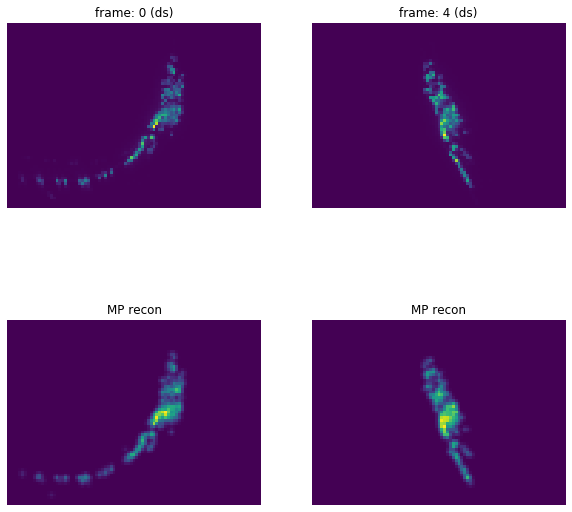

In [4]:
# Frames to load
t_start = 0
n_frames = 5
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    img_orig = [reader.get_frame(t) for t in t_vals]

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
with io.MPReader(mp_path) as reader:
    mps_orig = [reader.get_frame(t) for t in t_vals]

# Downsample images and MPs
scl_factors = (10, 10, 3)
img = [downscale_local_mean(x, scl_factors) for x in img_orig]
mps = [downsample_mp(x, scl_factors) for x in mps_orig]

# Reconstruct images from MPs
mp_img = [imagerep.reconstruct_mp_image(mp) for mp in mps]

# Indices to plot
k1 = 0
k2 = -1

plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img[k1])
plt.title(f'frame: {t_vals[k1]} (ds)')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img[k2])
plt.title(f'frame: {t_vals[k2]} (ds)')
plt.axis('off');

plt.subplot(223)
plot_maxproj(mp_img[k1])
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(mp_img[k2])
plt.title('MP recon')
plt.axis('off');

## Compute registrations for images

### Register all frames to first frame

In [5]:
models = [None] * (n_frames - 1)
debug = [None] * (n_frames - 1)

# Compute mapping from nth frame to first frame
for t in range(n_frames - 1):
    models[t], debug[t] = imagereg.ot_registration(mps[0], mps[t + 1], degree=1, n_iter=50)

### Reconstruct frames using mappings learned using both methods

In [34]:
#mp_straight = [mp_img[0]] + [None] * (n_frames - 1)
img_straight = [img[0]] + [None] * (n_frames - 1)

def img_map(x, model):
    
    x_arr = np.array(x).reshape(1, -1)
    y_arr = model.predict(x_arr)
    return (y_arr[0, 0], y_arr[0, 1], y_arr[0, 2])

for t in range(1, n_frames):
    
    #pb_pts = models[t - 1].predict(mps[0].pts)
    #pb_mp = imagerep.ImageMP(pb_pts, mps[0].wts, mps[0].cov, mps[0].img_shape)
    #mp_straight[t] = imagerep.reconstruct_mp_image(pb_mp)
    
    #map_t = partial(img_map, model=models[t - 1])
    #img_straight[t] = geometric_transform(img[t], map_t)
    
    offset = models[t - 1].beta[:, 0]
    coef = models[t - 1].beta[:, 1:]
    
    img_straight[t] = affine_transform(img[t], coef, offset)

### Plot single frame next to reconstruction

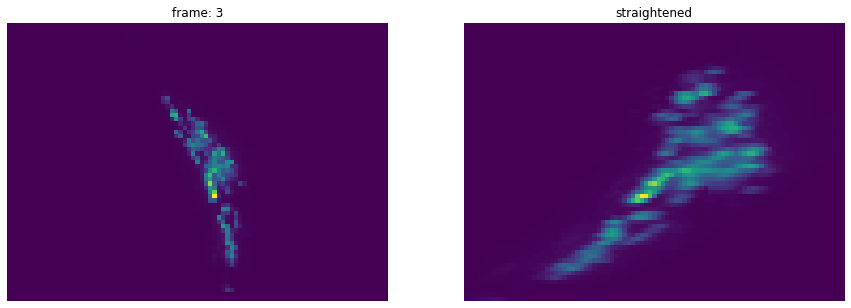

In [36]:
t = 3

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(img[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj(img_straight[t])
plt.title('straightened')
plt.axis('off');

#plt.subplot(121)
#plot_maxproj(mp_img[t])
#plt.title(f'frame: {t}')
#plt.axis('off')
        
#plt.subplot(122)
#plot_maxproj(mp_straight[t])
#plt.title('pushforward')
#plt.axis('off');

### Create video of all frame reconstructions

In [8]:
# fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 15))

# ax_1.set_title('frame: 0')
# ax_2.set_title('straightened')

# ax_1.axis('off')
# ax_2.axis('off')

# def animate(t):
    
#     ax_1.set_title(f'frame: {t}')
    
#     plot_maxproj(mp_img[t], ax=ax_1, animated=True)
#     plot_maxproj(rec[t], ax=ax_2, animated=True)
    
# ani = animation.FuncAnimation(fig, animate, n_frames)
# #ani.save('video_straight_ot.mp4')

# # Prevent double-display of animation
# plt.close()

# # Display animation in notebook
# HTML(ani.to_html5_video())